# Taiwan Eathquake Open data Kirging interpolation

In [1]:
## Common analysis packages
import pandas as PD
import numpy as NP
import matplotlib.pyplot as PLT
from tqdm import tqdm as TQDM

## geometry packages
import geopandas as GPD
import rasterio as RAST
from rasterio.transform import from_origin
from shapely.geometry import Point

## Load variogram object
from variogram import variogram as VARIOGRAM
from ordinarykriging import ordinarykriging as OK

## 1. Load earth quake data & split to training and test data

In [2]:
df = PD.read_csv('./data/earthquaketw.csv')
df.head()

,event,datetime,lon,lat,depth,intensity,station_id,station_name,station_lon,station_lat,distance,az,pga_v,pga_ns,pga_ew,d,pga_max,pga
0,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,TWD,Xiulin,311007.912765,2.664013e+06,8.22,255.19,8.24,5.79,8.24,7455.018061,8.24,13.012275
1,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETM,Tongmen,299865.343998,2.651787e+06,11.26,17.81,27.06,53.78,53.78,10766.259718,53.78,80.726826
2,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,HWA,HualienCity,312072.754264,2.652942e+06,13.09,317.56,15.05,14.58,15.05,12030.634070,15.05,25.798864
3,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETL,Taroko,313002.380630,2.672882e+06,14.44,222.69,5.94,19.33,19.33,14365.702485,19.33,27.974656
4,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETLH,Xibao,298756.774779,2.678364e+06,16.64,164.09,6.89,8.04,8.04,17372.811019,8.04,13.294935


In [3]:
NP.random.seed(0)
test_idxes = NP.random.choice(a=df.index, size=int(NP.round(len(df)/4)))
train_idxes = NP.array(list(set(df.index).difference(set(test_idxes))))
tw_test = df.loc[test_idxes,:].copy()
tw_train = df.loc[train_idxes,:].copy()
print(len(tw_train), len(tw_test), len(df))

1699 548 2191


## 2. Evaluation with training and test data

### 2.1. Check shape of variogram with training data
Since each event is independent, the calculation of variogram has to be done separately.

100%|██████████| 58/58 [00:00<00:00, 433.77it/s]


<Figure size 720x432 with 0 Axes>

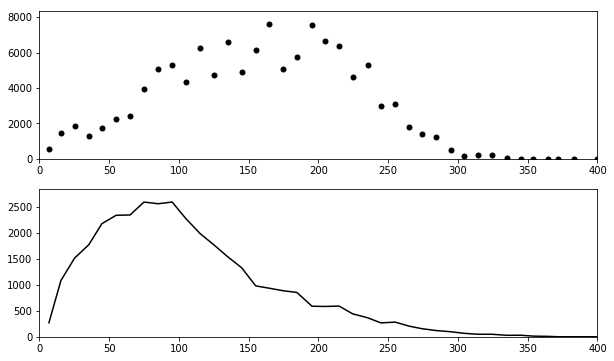

In [4]:
var_tw = VARIOGRAM(lag=10)
events = TQDM(df['event'].unique())
for evt in events:
    event = tw_train.query('event == %d'%evt)
    if len(event) == 0 : continue
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga'].values
    var_tw.calculate(X, y)
PLT.figure(figsize=[10,6])
var_tw.plot()

### 2.2. Fit variogram with expolantional function

In [ ]:
## Functions
def variogram_exponential(d, pars):
    """Exponential model, pars[3] = [psill, range, nugget]
                           d     
                      - ( --- )  
                          [1]    
    y = [0] * ( 1 - e^         ) + [2]
    """
    psill = float(pars[0])
    prange = float(pars[1])
    pnugget = float(pars[2])
    return psill * (1. - NP.exp(-d/(prange))) + pnugget

<Figure size 720x432 with 0 Axes>

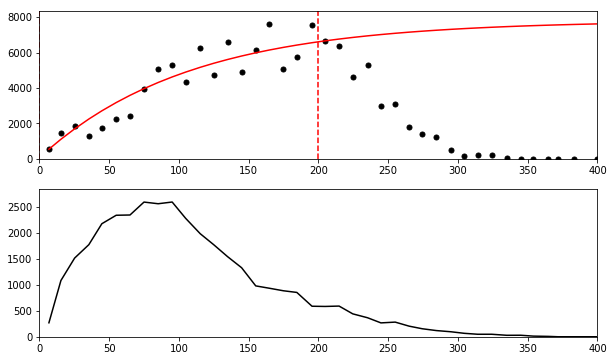

Sill 7803.577195
Range 107.064293
Nugget 73.111411
Fit chi2/ndf 0.064220
Fit r2 0.852284


In [ ]:
var_tw.model = variogram_exponential
var_tw.update_fit(fit_range=[0,200])
PLT.figure(figsize=[10,6])
var_tw.plot()
var_tw.summary()

### 2.3. Trianing Kriging prediction
Since each event is independent, the prediction and neighbors have to be in the same event. 

In [ ]:
## Create ordinary kriging object with input variogram
ok_tw = OK(var_tw)

## Evaluate event by event
events = TQDM(df['event'].unique())
for evt in events:
    msk_test  = tw_test['event'] == evt
    msk_train = tw_train['event'] == evt
    
    X_test  = tw_test.loc[msk_test, ['station_lon', 'station_lat']].values/1000
    X_train = tw_train.loc[msk_train, ['station_lon', 'station_lat']].values/1000
    y_train = tw_train.loc[msk_train, 'pga'].values
    
    ## Load train data point
    if len(X_train) == 0: 
        continue
    else:
        ok_tw.fit(X_train, y_train)
        tw_train.loc[msk_train, 'pga_predict'] = ok_tw.predict(X_train)[0]
        
    ## Load test data point
    if len(X_test) == 0:
        continue
    else:
        tw_test.loc[msk_test, 'pga_predict'] = ok_tw.predict(X_test)[0]
        
## obtain residual
tw_train['residual'] = tw_train['pga_predict'] - tw_train['pga']
tw_test['residual'] = tw_test['pga_predict'] - tw_test['pga']

100%|██████████| 58/58 [00:00<00:00, 83.82it/s]


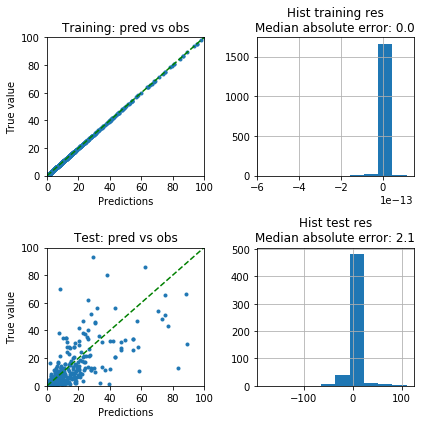

In [ ]:
## visulization
pga_limit = 100
PLT.figure(figsize=(6,6))
PLT.subplot(221)
PLT.plot(tw_train['pga_predict'], tw_train['pga'], '.')
PLT.title('Training: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.plot([0,pga_limit], [0,pga_limit], 'g--')
PLT.ylim(0,pga_limit)
PLT.xlim(0,pga_limit)
PLT.subplot(222)
tw_train['residual'].hist()
PLT.title('Hist training res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(tw_train['residual']))))
PLT.subplot(223)
PLT.plot(tw_test['pga_predict'], tw_test['pga'], '.')
PLT.plot([0,pga_limit], [0,pga_limit], 'g--')
PLT.title('Test: pred vs obs')
PLT.xlabel('Predictions')
PLT.ylabel('True value')
PLT.ylim(0,pga_limit)
PLT.xlim(0,pga_limit)
PLT.subplot(224)
tw_test['residual'].hist()
PLT.title('Hist test res\nMedian absolute error: {:.1f}'.format(NP.median(NP.abs(tw_test['residual']))))
PLT.tight_layout()

## 3. Generate raster data for visulization

### 3.1. Input all data for variogram and kriging

In [ ]:
var_tw = VARIOGRAM(10, model=variogram_exponential)
events = TQDM(df['event'].unique())
for evt in events:
    event = df.query('event == %d'%evt)
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga'].values
    var_tw.calculate(X, y)
var_tw.update_fit(fit_range=[0,200])

100%|██████████| 58/58 [00:00<00:00, 272.51it/s]


In [ ]:
ok_tw = OK(var_tw)

### 3.2. Make grids in the interseted region

In [ ]:
cellsize = 5000 # [m]
xmin = 145541
xmax = 355210
ymin = 2421543
ymax = 2800785
# * Create 2D extent and grid
## Grid is from top-left to bottom-right
X, Y = NP.meshgrid( NP.arange(xmin, xmax+cellsize, cellsize),
                    NP.arange(ymin, ymax+cellsize, cellsize))
## set prediction location is in the central of grid
xy = NP.concatenate(( X.flatten()[:, NP.newaxis] + cellsize/2,
                      Y.flatten()[:, NP.newaxis] - cellsize/2),
                      axis=1)
## Define variables
xbins = X.shape[1]
ybins = Y.shape[0]
transform = from_origin(X.min(), Y.max(), cellsize, cellsize) # Set raster left-top's coordinates
print(">> Interpolating %d cells (%d, %d)...."%(len(xy), xbins, ybins))

>> Interpolating 3311 cells (43, 77)....


### 3.3. Prediction and generate .tif event by event

In [ ]:
## Predict
events = TQDM(df['event'].unique())
for evt in events:
    ## Select event
    event = df.query('event == %d'%evt).reset_index(drop=True)
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga'].values
    name = event['datetime'].values[0].split()[0]
    
    ## ordinary prediction
    ok_tw.fit(X, y)
    prediction = ok_tw.predict(xy/1000.)
    #prediction = ok_tw.predict(xy/1000., radius=var_tw.range)
    
    ## raster data .tif
    raster = RAST.open('./data/pga_prediction_%d_%s.tif'%(evt, name),  
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=prediction[0].dtype,
                    crs='epsg:3826',
                    transform=transform )
    raster.write(NP.flip(prediction[0].reshape(ybins,xbins), 0), 1)
    raster.close()
    
    raster = RAST.open('./data/pga_prediction_error_%d_%s.tif'%(evt,name),                   
                   'w',
                    driver='GTiff',
                    height=ybins,
                    width=xbins,
                    count=1,
                    dtype=prediction[1].dtype,
                    crs='epsg:3826',
                    transform=transform )
    raster.write(NP.flip(prediction[1].reshape(ybins,xbins), 0), 1)
    raster.close()
    
    ## Create .shp file of events
    event['geom'] = event[['station_lon', 'station_lat']].apply(lambda x: Point(x), axis=1)
    event = GPD.GeoDataFrame(event[['event', 'depth', 'intensity', 'station_id', 'distance', 'az', 'pga_v', 'pga_ns', 'pga_ew', 'd', 'pga_max', 'pga', 'geom']], geometry='geom')
    event.crs={'init' :'epsg:3826'}
    event.to_file('./data/earthquaketw_%d_%s.shp'%(evt,name), driver='ESRI Shapefile', encoding = 'utf-8')

 12%|█▏        | 7/58 [00:04<00:23,  2.13it/s]